In [1]:
# How to install gdal
# The best is to install gdal and cartopy using conda, and then other packages using pip
# conda create -y -n rasterize gdal cartopy pip
# conda activate rasterize
# pip install jupyter netcdf4 # and other libs


import numpy as np
from osgeo import gdal, osr, ogr
import matplotlib.pyplot as plt

In [2]:
def get_gdal_dataset(x_ul, nx, dx, y_ul, ny, dy, srs_proj4, dtype=gdal.GDT_Float32):
    """
    Get empty gdal dataset with a given extent and projection

    Parameters:
    -----------
    x_ul : float
        x coordinates of upper-left corner of upper-left pixel
        ([0,0] pixel)
    nx   : int
        number of pixels in x-direction (number of columns)
    dx   : float
        step size in x direction (as column index increases)
        (can be negative)
    y_ul : float
        y coordinates of upper-left corner of upper-left pixel
        ([0,0] pixel)
    ny   : int
        number of pixels in y-direction (number of rows)
    dy   : float
        step size in y direction (as row index increases)
        (can be negative)

    Returns:
    --------
    ds : osgeo.gdal.Dataset
    """

    # create dataset
    dst_ds = gdal.GetDriverByName('MEM').Create('tmp', nx, ny, 1, dtype)

    # set grid limits
    # - for usage of osgeo.gdal.Dataset.SetGeoTransform, see:
    #   https://gdal.org/tutorials/geotransforms_tut.html
    dst_ds.SetGeoTransform((x_ul, dx, 0, y_ul, 0, dy))

    # set projection
    srs = osr.SpatialReference()
    srs.ImportFromProj4(str(srs_proj4))
    srs_wkt = srs.ExportToWkt()
    dst_ds.SetProjection(srs_wkt)

    # set no_data_value for the band
    band = dst_ds.GetRasterBand(1)
    NoData_value = -999999
    band.SetNoDataValue(NoData_value)
    band.FlushCache()

    return dst_ds

def rasterize_icehart(shapefile, ds):
    field_names = ['CT', 'CA', 'CB', 'CC', 'SA', 'SB', 'SC', 'FA', 'FB', 'FC']
    field_arr = []

    ivector = ogr.Open(shapefile, 0)
    ilayer = ivector.GetLayer()

    odriver = ogr.GetDriverByName('MEMORY')
    ovector = odriver.CreateDataSource('memData')
    olayer = ovector.CopyLayer(ilayer, 'burn_ice_layer', ['OVERWRITE=YES'])
    fidef = ogr.FieldDefn('poly_index', ogr.OFTInteger)
    olayer.CreateField(fidef)
    for ft in olayer:
        ft_id = ft.GetFID() + 1
        field_vec = [ft_id] + [float(ft.GetField(field_name)) for field_name in field_names]
        field_arr.append(field_vec)
        ft.SetField('poly_index', ft_id)
        olayer.SetFeature(ft)

    gdal.RasterizeLayer(ds, [1], olayer, options=["ATTRIBUTE=poly_index"])
    dst_arr = ds.ReadAsArray()
    return dst_arr, np.array(field_arr)


In [3]:
x_ul = -3850000.0
nx = 2432
dx = 3125.0
y_ul = 5850000.0
dy = -3125.0
ny = 3584
srs = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +x_0=0 +y_0=0 +a=6378273 +b=6356889.44891059 +units=m +no_defs'

shapefile = '/Data/sat/auxdata/ice_charts/NIC/arctic230113/ARCTIC230113.shp'
# burn poly_index values onto raster
ds = get_gdal_dataset(x_ul, nx, dx, y_ul, ny, dy, srs, gdal.GDT_Int16)
polyindex_arr, icecodes = rasterize_icehart(shapefile, ds)


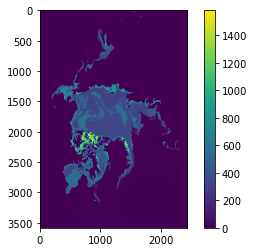

In [4]:
plt.imshow(polyindex_arr)
plt.colorbar()

In [5]:
print(icecodes)

[[ 1.000e+00  0.000e+00  0.000e+00 ... -9.000e+00 -9.000e+00 -9.000e+00]
 [ 2.000e+00  0.000e+00  0.000e+00 ... -9.000e+00 -9.000e+00 -9.000e+00]
 [ 3.000e+00  0.000e+00  0.000e+00 ... -9.000e+00 -9.000e+00 -9.000e+00]
 ...
 [ 1.580e+03  9.200e+01  9.200e+01 ... -9.000e+00 -9.000e+00 -9.000e+00]
 [ 1.581e+03  9.200e+01  9.200e+01 ... -9.000e+00 -9.000e+00 -9.000e+00]
 [ 1.582e+03  9.200e+01  9.200e+01 ... -9.000e+00 -9.000e+00 -9.000e+00]]


In [7]:
ct_array = np.zeros(polyindex_arr.shape, float)
polyids = np.unique(polyindex_arr)
for polyid in polyids:
    mask = polyindex_arr == polyid
    i = np.where(icecodes[:,0] == polyid)[0]
    if i:
        ct = icecodes[i,1]
        ct_array[mask] = ct

/tmp/ipykernel_68449/3302267334.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if i:


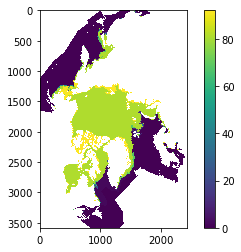

In [8]:
ct_array[polyindex_arr == 0] = np.nan
plt.imshow(ct_array, interpolation='nearest')
plt.colorbar()

In [ ]:
# more SHAPEFILES file here:
# https://usicecenter.gov/Products/ArchiveSearch?table=WeeklyArctic&product=Arctic%20Weekly%20Shapefile&linkChange=arc-two
!ogrinfo -al -geom=NO /Data/sat/auxdata/ice_charts/NIC/arctic230113/ARCTIC230113.shp


In [48]:
m1 = np.random.randint(0, 15, (10,15))
m2 = np.random.randint(0, 15, (10,15))
m3 = np.random.randint(0, 15, (10,15))

p1 = np.random.random_sample((10,15))
p2 = np.random.random_sample((10,15))
p3 = np.random.random_sample((10,15))

In [49]:
cols, rows = np.meshgrid(range(15), range(10))
sum_prob = np.zeros((10,15,4))

for p, m in zip([p1, p2, p3], [m1, m2, m3]):
    gpi = m < 4
    sum_prob[rows[gpi], cols[gpi], m[gpi]] += p[gpi]

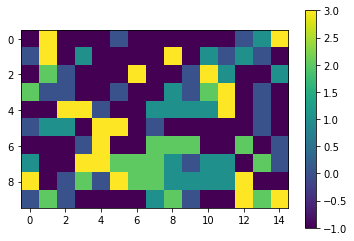

In [50]:
max_prob_idx = np.argmax(sum_prob, axis=2)

max_prob_idx[sum_prob.sum(axis=2) == 0] = -1

plt.imshow(max_prob_idx)
plt.colorbar()

In [30]:
m1.max()

2